# Brief Introduction
> Can a 2-hidden-layer MLP do a good job classifying musical instrument sounds? Let's find out!

# Introduction

For beginner guitar players, it's sometimes difficult to tell apart the sound of steel strings vs nylon strings on the guitar.
In this article, I'll walk you through some easy steps to build a Machine Learning model to classify the two aforemtioned types of sound.

You can try a live DEMO via:

https://nqhoang2077-steel-nylon-streamlitapp-streamlit-app-8sd4cc.streamlit.app/

# Import libraries & Setup constants

The first step is to install all required libraries. Even though torchaudio could handle audio, they lack support for some media formats. That's why we need two additional sound libraries, namely libosa and soundfile.
Our main data source is YouTube, and pytube allows easy and fast audio extraction from the social media platform.

In [2]:
!pip install torchaudio librosa soundfile pytube torchsummary matplotlib pandas

     |████████████████████████████████| 56 kB 3.6 MB/s  eta 0:00:01


In [ ]:
!conda install libsoundfile

In [1]:
import torch
import torchaudio
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import threading
from glob import glob
import os


Use Google Drive if you need to store your data there.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


For simplicity, I will use 8000 Hz as the default sampling rate. This helps training faster on modest hardware.
Also, I'd like to segment each YouTube audio clip into chunks of 5-second clip for training. This help us enrich our dataset and simplify our network architecture.

In [32]:
TARGET_SR = 8_000
CLASSES = ["nylon", "steel"]
SEGMENT_DURATION = 5 # seconds
RANDOM_SEED = 42
TRAIN_SIZE = .95

torch.random.manual_seed(RANDOM_SEED)

Then, we will create some folders to store our sound files.

In [3]:
ROOT_DIR = "./"
DATA_DIR = f"{ROOT_DIR}data/" # Google Drive & Colab

for subfolder in ["raw", "segments"]:
  for cls in CLASSES:
    new_dir = f"{DATA_DIR}{subfolder}/{cls}"
    if not os.path.exists(new_dir):
      os.makedirs(new_dir)

SEGMENT_DIR = f"{DATA_DIR}segments/"
RAW_CLIP_PATH = f"{DATA_DIR}raw/"

This function helps get the best device possible for training.

In [4]:
def get_best_torch_device():
  if torch.cuda.is_available():
      device = "cuda"
  else:
      device = "cpu"
  print(f"Using device {device}")
  return device

device = get_best_torch_device()

Using device cuda


# Collect Data

## Download audio from YouTube


These are the clips that I handpicked from YouTube. They are solo guitar recordings and were recorded in a professional studio.
To watch any of them, just add the youtube url prefix. For example:
**"foIPN-T7RGo" ➡️ "youtube.com/watch?v=foIPN-T7RGo"**

In [10]:
steel_clips = ["foIPN-T7RGo","10ATKnZLg9c","IP8vBL5Q8Ac"]
nylon_clips = ["qgb-bdEEI-M","qXwvz-nTiog","6jQ34uTmA9s"]

Next, we define our function to download and extract audio from a YouTube url:

In [11]:
from pytube import YouTube

def download_youtube_mp3(link, output_dir):
    """
    Download and extract audio from a clip from youtube 
    """
    yt=YouTube(f"youtube.com/watch?v={link}")
    t=yt.streams.filter(only_audio=True).first().download(output_dir, link + ".mp3")
    print(f"Downloaded YouTube Audio from: {link}")

Each clip is over 60 minutes long, which could take a long time to download.
To accelerate, we will create a downloading thread for each clip and download all clips simultaneously.

In [12]:
download_thread_list = []

for link in steel_clips:
  new_thread = threading.Thread(target=download_youtube_mp3, args=(link, RAW_CLIP_PATH + "steel"))
  download_thread_list.append(new_thread)

for link in nylon_clips:
  new_thread = threading.Thread(target=download_youtube_mp3, args=(link, RAW_CLIP_PATH + "nylon"))
  download_thread_list.append(new_thread)

In [13]:
print("Download Raw Clips starting...")
# start each thread
for thread in download_thread_list:
  thread.start()

# wait for all to finish
for thread in download_thread_list:
  thread.join()

# successfully excecuted
print("Download Raw Clips finished!")

Download Raw Clips starting...
Downloaded YouTube Audio from: foIPN-T7RGo
Downloaded YouTube Audio from: 6jQ34uTmA9s
Downloaded YouTube Audio from: qgb-bdEEI-M
Downloaded YouTube Audio from: qXwvz-nTiog
Downloaded YouTube Audio from: 10ATKnZLg9c
Downloaded YouTube Audio from: IP8vBL5Q8Ac
Download Raw Clips finished!


## Segmentize into 5-second clips

Now, let's create some function to segment each audio clip into segments of 5 second long.

In [14]:
def segmentize_signal(signal, sr, dur):
    """
    Segmentize the 1-d signal (mono) to a list of clips with custom duration (dur).
    """
    seg_len = dur * sr

    # calculate number of segments
    no_segs = len(signal) // seg_len


    # truncate input signal to have length divisiable by seg_len
    trunc_len = int(no_segs * seg_len)

    # split equally
    return np.split(signal[:trunc_len], no_segs)

def save_audio(signal, sr, output_dir, filename):
    output_path = os.path.join(output_dir, filename)
    # torchaudio.save(output_path, signal, sr)
    # print(output_path, sr)
    sf.write(output_path, signal, sr)

def segment_audio_file(audio_path, output_dir,  target_sr=TARGET_SR, segment_duration=SEGMENT_DURATION):
    print(f"Processing raw clip: {audio_path}")
    signal, _ = librosa.load(audio_path, sr=target_sr, mono=True)
    # signal, target_sr = librosa.load(audio_path,sr=None,  mono=True)
    print(f"\tLoaded clip from disk")
    segments_list = segmentize_signal(signal, target_sr, segment_duration)
    print(f"\tSegmented clip into {len(segments_list)} segments")
    for seg_idx, seg in enumerate(segments_list):
        seg_name = f"{audio_path.split('/')[-1][:-4]}_{seg_idx}.wav"
        save_audio(seg, target_sr, output_dir, seg_name)
    print(f"\tSegments are saved completely")

Next, we use threading to segmentize all clips at the same time. Beware that if your system has less than 32GB of RAM, this could cause the system to freeze and run out of memory. In such case, please modify the code before do it sequentially (i.e. without threading)

In [17]:
thread_list = []

for cls in CLASSES:
# get all raw files from subfolders
    raw_audio_paths = glob(f"{RAW_CLIP_PATH}{cls}/*mp3")
    for audio_path in raw_audio_paths:
        output_dir = f"{SEGMENT_DIR}{cls}"
        new_thread = threading.Thread(target=segment_audio_file, args=(audio_path, output_dir))
        thread_list.append(new_thread)
        
print("Segmentation starting...")
# start each thread
for thread in thread_list:
  thread.start()

# wait for all to finish
for thread in thread_list:
  thread.join()

# successfully excecuted
print("Segmentation finished!")

Segmentation starting...
Processing raw clip: /workspace/data/raw/nylon/qXwvz-nTiog.mp3
Processing raw clip: /workspace/data/raw/nylon/6jQ34uTmA9s.mp3
Processing raw clip: /workspace/data/raw/nylon/qgb-bdEEI-M.mp3
Processing raw clip: /workspace/data/raw/steel/IP8vBL5Q8Ac.mp3
Processing raw clip: /workspace/data/raw/steel/foIPN-T7RGo.mp3


/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Processing raw clip: /workspace/data/raw/steel/10ATKnZLg9c.mp3


/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


	Loaded clip from disk
	Segmented clip into 648 segments
	Segments are saved completely
	Loaded clip from disk
	Segmented clip into 742 segments
	Segments are saved completely
	Loaded clip from disk
	Segmented clip into 1230 segments
	Segments are saved completely
	Loaded clip from disk
	Segmented clip into 1251 segments
	Segments are saved completely
	Loaded clip from disk
	Segmented clip into 1427 segments
	Segments are saved completely
	Loaded clip from disk
	Segmented clip into 2647 segments
	Segments are saved completely
Segmentation finished!


# Dataset & Dataloader

PyTorch manages data through two types of classes: Dataset and Data;oader.
Dataset could be thought of as an iterator that allows us to access each individual data point.
And, Dataloader is a way to efficiently load data in batch, which is useful for mini-batch training.
For more detailed description, read here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

## Create annotations

Before creating our own dataset class, we need to have a csv file to describe our training / val / test sets.

This annotation dataframe stores the paths to each audio sample and its label:

In [5]:
annotation_dict = {"audio_path": [], "label": []}


for label, cls in enumerate(CLASSES):
  wav_dirs = f"{SEGMENT_DIR}{cls}/*wav"
  audio_path_list = glob(wav_dirs)
  count_audio_files = len(audio_path_list)
  label_list = [label] * count_audio_files

  annotation_dict["audio_path"] += audio_path_list
  annotation_dict["label"]      += label_list

In [6]:
annotation_df = pd.DataFrame.from_dict(annotation_dict)
annotation_df.tail()

,audio_path,label
7940,./data/segments/steel/foIPN-T7RGo_575.wav,1
7941,./data/segments/steel/10ATKnZLg9c_545.wav,1
7942,./data/segments/steel/10ATKnZLg9c_1035.wav,1
7943,./data/segments/steel/10ATKnZLg9c_602.wav,1
7944,./data/segments/steel/IP8vBL5Q8Ac_1146.wav,1


The data is quite enormously for an average system. That's why I seperated the training data set to full, half, quarter, and one eighth. This allows me to build and test model fast (by using a smaller training dataset). When I find something that works well, I can then use a larger training dataset to improve the training.

In [7]:
train_df_full = annotation_df.sample(frac=TRAIN_SIZE, random_state=RANDOM_SEED)
val_df = annotation_df.drop(train_df_full.index, axis=0)

# make smaller train datasets for quick experimentations
train_df_half = train_df_full.sample(frac=1/2, random_state=RANDOM_SEED)
train_df_quarter = train_df_full.sample(frac=1/4, random_state=RANDOM_SEED)
train_df_1eight = train_df_full.sample(frac=1/8, random_state=RANDOM_SEED)

We have 4816 samples of NYLON, and 3129 of STEEL

In [28]:
annotation_df["label"].value_counts()

0    4816
1    3129
Name: label, dtype: int64

Finally, let's write them to CSV files for later use.

In [8]:
df_list = [train_df_full, train_df_half, train_df_quarter, train_df_1eight, val_df]

df_names = ["train_df_full", "train_df_half", "train_df_quarter", "train_df_1eight", "val_df"]

for df_name, df_content in zip(df_names, df_list):
    df_content.to_csv(f"{DATA_DIR}{df_name}.csv", index=False)

## Dataset class

We create GuitarSoundDataset which inherets Dataset from PyTorch. This class holds the annotation that we created earlier and helps us access and preprocess each individual input and label.

To create this class, I took inspiration from this awesome Deep Learning for Audio channel: https://www.youtube.com/watch?v=iCwMQJnKk2c&t=1s&ab_channel=ValerioVelardo-TheSoundofAI

In [33]:
from torch.utils.data import Dataset

class GuitarSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device,
                 audio_col="audio_path",
                 label_col="label"):
        self.annotations = pd.read_csv(annotations_file)
        self.device = device
        if transformation:
          self.transformation = transformation.to(self.device)
        else:
          self.transformation = None
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.audio_col = audio_col
        self.label_col = label_col

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self.__get_audio_sample_path(index)
        label = self.__get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        if signal.dim() < 2:
          signal = signal[None, :]
        signal = signal.to(self.device)
        signal, sr = self.preprocess_signal(signal, sr)
        if self.transformation:
          signal = self.transformation(signal)
        return signal, label

    def preprocess_signal(self, signal, sr):
        signal = self.__resample_if_necessary(signal, sr)
        signal = self.__mix_down_if_necessary(signal)
        signal = self.__cut_if_necessary(signal)
        signal = self.__right_pad_if_necessary(signal)
        return signal, sr

    def __cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def __right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def __resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def __mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def __get_audio_sample_path(self, index):
        path = self.annotations.iloc[index, :][self.audio_col]
        return path

    def __get_audio_sample_label(self, index):
        label =  self.annotations.iloc[index, :][self.label_col]
        return torch.tensor(label, dtype=torch.float)

## DataLoader

In [34]:
from torch.utils.data import DataLoader

def create_data_loader(dataset, batch_size):
    dataset_loader = DataLoader(dataset, batch_size=batch_size)
    return dataset_loader

Mel Spectrogram transforms our signal from time-domain into frequency-domain, which helps not only human but also computers to understand the characteristic of sound input better. Thus, we need to transform each audio input into mel spec before feeding it into the neural network.

In [54]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=TARGET_SR,
      n_fft=1024,
      hop_length=512,
      n_mels=64
  )

train_dataset = GuitarSoundDataset(
                      annotations_file =f"{DATA_DIR}train_df_half.csv",
                      transformation = mel_spectrogram,
                      target_sample_rate = TARGET_SR,
                      num_samples = TARGET_SR * SEGMENT_DURATION,
                      device = device)
print(f"There are {len(train_dataset)} samples in the TRAIN dataset.")

val_dataset = GuitarSoundDataset(f"{DATA_DIR}val_df.csv",
                      transformation = mel_spectrogram,
                      target_sample_rate = TARGET_SR,
                      num_samples = TARGET_SR * SEGMENT_DURATION,
                      device = device)
print(f"There are {len(val_dataset)} samples in the VAL dataset.")

There are 3774 samples in the TRAIN dataset.
There are 397 samples in the VAL dataset.


We will take one sample out to find out the exact input shape for our neural network

In [38]:
signal_sample, _ = val_dataset[0]
signal_sample.shape

torch.Size([1, 64, 79])

# Build Model

## Training Loop

Because the training and validating loops are pretty basic, I don't delve into these code too much. 
The official tutorial is where I took inspiration from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [12]:
def compute_accuracy(preds, target):
  _preds = preds.detach().cpu().numpy()
  _target = target.detach().cpu().numpy()
  return np.mean(_preds.squeeze().round() == _target.squeeze())

def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
  size = len(data_loader.dataset)
  train_losses = []
  train_accs = []

  model.train(True)
  for batch, (input, target) in enumerate(data_loader):
      input, target = input.to(device), target.to(device)

      # calculate loss
      preds = model(input)
      loss = loss_fn(preds.squeeze(), target.squeeze())
      train_losses.append(loss.item())


      # backpropagate error and update weights
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      # calculate accuracy
      acc = compute_accuracy(preds, target)
      train_accs.append(acc)

  return np.mean(train_losses), np.mean(train_accs)

def validate(model, data_loader, loss_fn, device):
  # model.train(False)
  val_losses = []
  val_accs = []
  with torch.inference_mode():
    for input, target in data_loader:
      input, target = input.to(device), target.to(device)

      # calculate loss
      preds = model(input)
      loss = loss_fn(preds.squeeze(), target.squeeze())
      val_losses.append(loss.item())

      # calculate acc
      acc = compute_accuracy(preds, target)
      val_accs.append(acc)

    return np.mean(val_losses), np.mean(val_accs)

def save_model(model, model_dir):
  torch.save(model.state_dict(), model_dir)

def train(model, train_dataloader, test_dataloader, loss_fn, optimiser, device, epochs, save_best=True, model_dir="bestmodel.pth"):
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  for i in range(epochs):
      # training
      train_loss, train_acc = train_single_epoch(model, train_dataloader, loss_fn, optimiser, device)
      # val
      val_loss, val_acc = validate(model, test_dataloader, loss_fn, device)
      print(f"Epoch {i+1} | train loss: {train_loss:.5f}, train acc: {train_acc:.3%} | val loss: {val_loss:.5f}, val acc: {val_acc:.3%}")

      # save best val acc
      if save_best and len(val_losses) > 0 and val_acc > np.max(val_accs):
        # save model
        print("-> Best Model found! Saving to disk...")
        save_model(model, model_dir)

      # update losses
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      train_accs.append(train_acc)
      val_accs.append(val_acc)
  print("Finished training")
  return train_losses, train_accs, val_losses, val_accs

In [13]:
def plot_model(model_history):
    train_losses, train_accs, val_losses, val_accs = model_history
    # Plot Loss
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(train_losses)), val_losses, label='Validation Loss')
    
    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper left")
    plt.show()    
    
    # Plot Acc
    plt.plot(range(len(train_accs)), train_accs, label='Training Acc')
    plt.plot(range(len(train_accs)), val_accs, label='Validation Acc')
    
    # Add in a title and axes labels
    plt.title('Training and Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    
def describe_model_stats(model_history):
    train_losses, train_accs, val_losses, val_accs = model_history
    history = {"train_losses": train_losses, "train_accs": train_accs, "val_losses": val_losses, "val_accs": val_accs}
    print(pd.DataFrame.from_dict(history).describe())    

## MLP Model Building: 2 hidden layers with ReLu Activation

I define a simple MLP with 2 hidden fully connected layers with relu activation. The final output is then taken by sigmoid to produce probabily prediction.

In [40]:
from torch import nn
from torchsummary import summary


class MLPNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(1 * 64 * 79, 256), # I got the number (1 * 64 * 79) as input size from the code above
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, input_data):
        x = self.flatten(input_data)
        logits = self.linear(x)
        predictions = torch.sigmoid(logits)
        return predictions
        # return x


if __name__ == "__main__":
    model2 = MLPNetwork()
    summary(model2.to(device), (1, 64, 79))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 5056]               0
            Linear-2                  [-1, 256]       1,294,592
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                    [-1, 1]             129
Total params: 1,327,617
Trainable params: 1,327,617
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 5.06
Estimated Total Size (MB): 5.13
----------------------------------------------------------------


Audio input is complex, with an audio sample of 5-second long at 8000 Hz sampling rate, we have an input of 5056 already.

And, this simple MLP model already has 1.3+ millions params.

Now, let's create a folder to store our trained params.

In [41]:
MODEL_DIR = f"{ROOT_DIR}weights/"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Then, define some hyper params for training and create dataloader for each training and validation dataset

In [44]:
BATCH_SIZE = 128
EPOCHS = 15
LEARNING_RATE = 0.001
    
train_dataloader = create_data_loader(train_dataset, BATCH_SIZE)
val_dataloader = create_data_loader(val_dataset, BATCH_SIZE)

Now, let's train our model!

In [45]:
MODEL_SAVE_PATH = f"{MODEL_DIR}model_mlp1.pth"
print(f"Best models will saved to: {MODEL_DIR} (based on val acc)")

model1 = MLPNetwork()


if os.path.exists(MODEL_SAVE_PATH):
  model1.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device(device)))

model1 = model1.to(device)

# initialise loss funtion + optimiser
loss_fn = nn.BCELoss()

optimiser = torch.optim.Adam(model1.parameters(),
                                lr=LEARNING_RATE)

# train model
history_model1 = train(model1, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS, save_best=True, model_dir=MODEL_SAVE_PATH)

Best models will saved to: ./weights/ (based on val acc)
Epoch 1 | train loss: 18.60054, train acc: 74.353% | val loss: 18.41207, val acc: 79.943%
Epoch 2 | train loss: 16.17105, train acc: 80.607% | val loss: 14.15756, val acc: 82.287%
-> Best Model found! Saving to disk...
Epoch 3 | train loss: 16.04773, train acc: 79.716% | val loss: 22.44626, val acc: 72.251%
Epoch 4 | train loss: 15.91658, train acc: 80.841% | val loss: 24.57104, val acc: 72.446%
Epoch 5 | train loss: 15.68584, train acc: 81.720% | val loss: 26.59615, val acc: 71.274%
Epoch 6 | train loss: 17.09794, train acc: 80.188% | val loss: 15.84533, val acc: 81.671%
Epoch 7 | train loss: 15.53885, train acc: 82.014% | val loss: 15.38519, val acc: 80.364%
Epoch 8 | train loss: 12.86597, train acc: 84.409% | val loss: 19.71215, val acc: 75.931%
Epoch 9 | train loss: 12.15642, train acc: 85.247% | val loss: 13.57315, val acc: 81.926%
Epoch 10 | train loss: 11.81812, train acc: 84.438% | val loss: 12.96833, val acc: 81.145%
Epo

       train_losses  train_accs  val_losses   val_accs
count     15.000000   15.000000   15.000000  15.000000
mean      12.388064    0.836627   14.304709   0.798988
std        4.770562    0.042507    7.314085   0.046287
min        2.194033    0.743532    1.491129   0.712740
25%        9.496942    0.807237    8.943201   0.779372
50%       12.865967    0.844086   14.157557   0.816707
75%       15.982155    0.873198   19.062112   0.829703
max       18.600537    0.892641   26.596150   0.848257


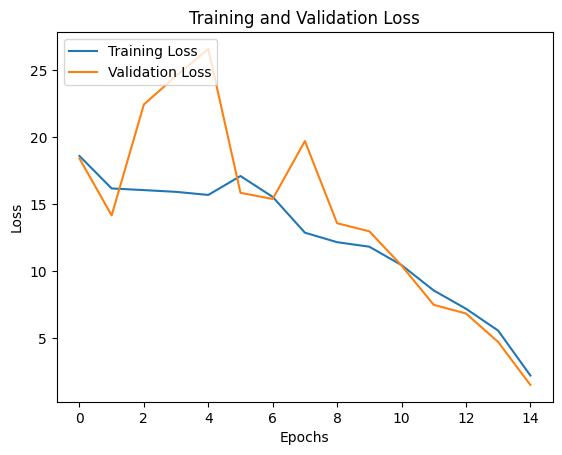

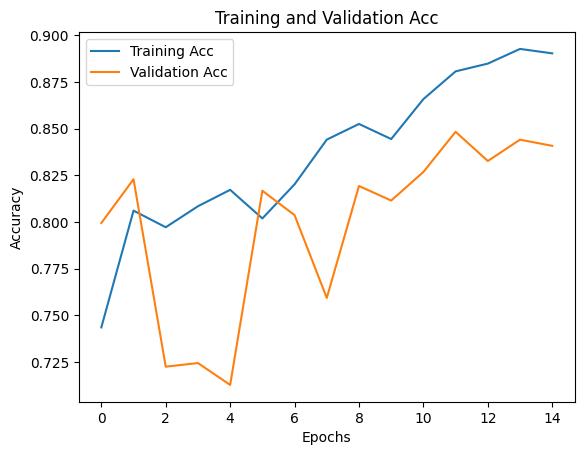

In [47]:
describe_model_stats(history_model1)
plot_model(history_model1)

# Conclusion

With this simple architecture, we already achieve an acceptable accuracy of round 81%.
Not bad for our first try.

In the live demo, I actually used a more complicated CNN model which achieves over 90% validation accuracy. The training was made possibly by running on a GPU cloud with RTX3090, AMD EPYC Cpu and 83GB of RAM. You can [try them out here - RunPod](https://runpod.io?ref=c7xd5dcy) (my affiliate link)

# Acknowledgment

I would like to thank [AI VIETNAM](https://www.facebook.com/aivietnam.edu.vn) for providing the basic knowledge about mathematics and machine learning model, and [Valerio Velardo](https://www.youtube.com/@ValerioVelardoTheSoundofAI) for his tutorials about working with sound data. Last but not least, I give my thanks to all the artists whose clips I used in this model which is for educational purpose.